<a href="https://colab.research.google.com/github/kevinyang1704/Blog-Posts/blob/main/Mean2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statsmodels.api as sm
from scipy import stats


In [ ]:
size = 1000 # Size of your sample

# Users pre-treatment data will be drawn from a normal distribution with some mean and variance (assuming normality is convenient, not required)
predata_mean = 1
pre_data_var = 1

# To generate post treatment data, we'll
true_beta = 0
error_var = 10

# Finally we'll implement a true effect (this is not required)
true_effect = 1


In [ ]:
treatment = np.random.randint(2, size=size)
pre_data = np.random.normal(predata_mean, pre_data_var, size)
post_data = true_beta*pre_data + np.random.normal(0, error_var, size)


df = pd.DataFrame({'treatment': treatment, 'pre_data': pre_data, 'post_data': post_data})

In [ ]:
df.head()

,treatment,pre_data,post_data
0,0,0.000381,4.019411
1,0,0.014827,13.005336
2,1,0.271014,7.028306
3,0,-0.310385,-3.516433
4,0,0.882804,-2.314829


In [ ]:
df['post_data'] = np.where(df['treatment']==0,df['post_data'],true_effect+df['post_data'])

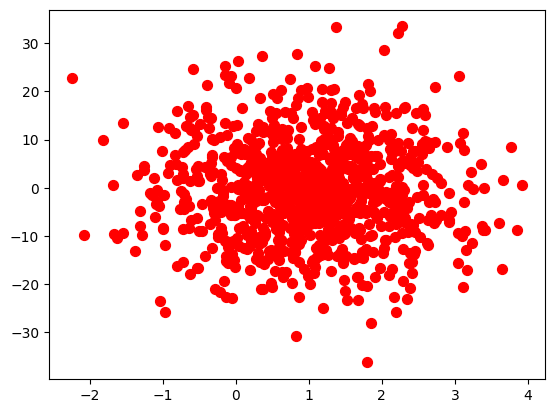

In [ ]:
plt.scatter(pre_data, post_data, s=50, c='red', marker='o')
plt.show()

In [ ]:
# Center Pre-Treatment
df['pre_data_centered'] = df['pre_data'] - np.mean(df['pre_data'])

# Create Interaction
df['interact'] =  df['pre_data_centered']*df['treatment']

# Convert to floats to work with statsmodels
df['pre_data']=df['pre_data'].astype(float)
df['post_data']=df['post_data'].astype(float)
df['treatment'] = df['treatment'].astype(float)
df['pre_data_centered'] = df['pre_data_centered'].astype(float)
df['interact'] = df['interact'].astype(float)

In [ ]:
X = df[['treatment','pre_data_centered','interact']]
y = df['post_data']
X = sm.add_constant(X)
model = sm.OLS(y, X,)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              post_data   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.525
Date:                Sun, 20 Oct 2024   Prob (F-statistic):             0.0146
Time:                        15:59:43   Log-Likelihood:                -3718.2
No. Observations:                1000   AIC:                             7444.
Df Residuals:                     996   BIC:                             7464.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.6577      0.43

In [ ]:
beta_control = results.params['pre_data_centered']
beta_test = results.params['pre_data_centered']+results.params['interact']

In [ ]:
unadj_test_mean = np.mean(df[df['treatment']==1]['post_data'])
unadj_cont_mean = np.mean(df[df['treatment']==0]['post_data'])

# Treatment Mean (in deltoid) = raw_mean_test + beta_test(pre_mean_pooled - pre_mean_test)
final_test_mean = np.mean(df[df['treatment']==1]['post_data']) + beta_test*(np.mean(df['pre_data']) - np.mean(df[df['treatment']==1]['pre_data']) )
# Control Mean (in deltoid) = raw_mean_control + beta_control(pre_mean_pooled - pre_mean_control)
final_control_mean = np.mean(df[df['treatment']==0]['post_data']) + beta_control*(np.mean(df['pre_data']) - np.mean(df[df['treatment']==0]['pre_data']) )

print('Adj Control Mean:',np.round(final_control_mean,4),'Adj Test Mean:',np.round(final_test_mean,4), 'Adj Mean Delta', np.round(final_test_mean-final_control_mean,4))
print('Control Mean:',np.round(unadj_cont_mean,4),'Test Mean:',np.round(unadj_test_mean,4), 'Mean Delta', np.round(unadj_test_mean-unadj_cont_mean,4))
# P-values
print('p-value:', np.round(results.pvalues['treatment'],4))
# Confidence Interval
print('[',np.round((final_test_mean-final_control_mean)-results.bse['treatment']*1.96,4),',', np.round((final_test_mean-final_control_mean)+results.bse['treatment']*1.96,4),']')

Adj Control Mean: -0.6577 Adj Test Mean: 1.2261 Adj Mean Delta 1.8838
Control Mean: -0.6505 Test Mean: 1.2282 Mean Delta 1.8787
p-value: 0.003
[ 0.6426 , 3.125 ]


In [ ]:
# Regular Mean

control = df[df['treatment'] == 0]['post_data']
test = df[df['treatment'] == 1]['post_data']

# Calculate the mean difference
mean_diff = np.mean(test) - np.mean(control)

# Calculate the standard error of the difference
std_err = np.sqrt((np.var(test) / len(test)) + (np.var(control) / len(control)))

# Calculate the t-statistic and p-value
t_stat, p_value = stats.ttest_ind(test, control)

# Calculate the confidence interval
conf_int = stats.t.interval(0.95, len(test) + len(control) - 2, loc=mean_diff, scale=std_err)

print("Mean difference:", mean_diff)
print("P-value:", p_value)
print("Confidence interval:", np.round(conf_int,4))